# Projet 5 : Segmentez les comportements de clients
# <u>C. Modèle de classification automatique des clients</u> <br/>

# Le contexte

Notre employeur Datazon souhaite mieux comprendre le comportements de ses clients afin de faire de meilleures ventes et augmenter son chiffre d'affaire.

Notre **objectif** est de mieux comprendre les clients afin de les classer en catégories et de déterminer automatiquement la catégorie d'un client dès son premier achat.

Ce notebook traite de la partie classification automatique des clients pour trouver leur type de catégorie. Pour celà nous allons tester et évaluer différents modéles de classification.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import seaborn as sns
import datetime as dt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import  manifold, cluster
from IPython.display import display

from sklearn import model_selection, metrics
from sklearn.svm import SVC
from sklearn import neighbors, linear_model, svm, tree, ensemble
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import confusion_matrix,roc_curve, auc
import itertools
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import label_binarize


%matplotlib inline

## 1. Tests des modèles de classification sur le découpage temporel des achats

Dans cette section nous avons évaluer différents algorithmes de classification capable de determiner la catégorie (cluster) d'un client.
Nous allons comparer la catégorie prédite par rapport à celle determinée avec KMeans pour vérifier la précision du modèle.
Nous commençons pas notre jeu de données découpé de manière temporelle.

## 1.1. Importation des données

On importe notre base clients contenant la segmentation trouvée dans la partie précédente.
Pour rappel, nous avions découpé nos données en jeu de d'apprentissage et jeu de test. Le jeu d'apprentissage a été utilisé pour trouver les clusters.

In [2]:
customers_clusters_TS = pd.read_csv('customers_clusters_TS.csv')

In [3]:
customers_clusters_TS.shape

(3349, 12)

## 1.2 Préparation des données

Notre target variable et le numéro de cluster.
On utilise les autres features pour notre apprentissage (en supprimant bien-sûr l'identifiant client et l'information sur le cluster).

La target variable et le numéro de cluster du client.

In [4]:
Y = customers_clusters_TS['Cluster']
X = customers_clusters_TS.drop(['Cluster'], axis=1)

On découpe les données en jeu d'entrainement et de test pour notre apprentissage (70% / 30%).
Le jeu de test permettra de mesurer la qualité de la prédiction.

In [5]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(X,Y,test_size = 0.3,random_state = 0)

## 1.3 Evaluation des modèles

Pour évaluer la qualité des modèles de classification, on a écrit quelque méthodes génériques qui seront utilisées par la suite.

In [6]:
'''
Méthode générique pour faire une recherche sur grille et évaluer le modèle de classification.
Affiche les meilleurs paramètres et la précision du modèle.
'''
def evaluateClassifier(classifier, parameters, x_train, y_train, x_test, y_test) :
    Kfold = 5
    gs_classifier = GridSearchCV(estimator = classifier, param_grid = parameters, cv = Kfold)
    fit = gs_classifier.fit(x_train, y_train)
    print("Best params :", gs_classifier.best_params_)
    y_pred = gs_classifier.predict(x_test)
    
    print("Classification accuracy: {:.2f} % ".format(100*metrics.accuracy_score(y_test, y_pred)))
    return gs_classifier, y_pred

In [7]:
'''
Affichage de la matrice de confusion
'''
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    #_________________________________________________
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    #_________________________________________________
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #_________________________________________________
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
def displayConfusionMatrix(y_test, y_pred,n_classes) :
    class_names = [i for i in range(n_classes)]
    cnf_matrix = confusion_matrix(y_test, y_pred) 
    np.set_printoptions(precision=2)
    plt.figure(figsize = (5,5))
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = False, title='Confusion matrix')

Pour tous les modèles testés, nous allons faire la recherche sur grille pour trouver les meilleurs hyperparamètres et la validation croisée pour éviter le surapprentissage.

### 1.3.1 SVM Linéaire

On commence par tester le modèle de machine à vecteurs de support.

In [8]:
svc = svm.LinearSVC()
parameters = [{'C':np.logspace(-3,3,10)}]
svc_grid, y_pred = evaluateClassifier(svc,parameters, x_train, y_train, x_test, y_test  )

Best params : {'C': 2.154434690031882}
Classification accuracy: 97.71 % 


Confusion matrix, without normalization


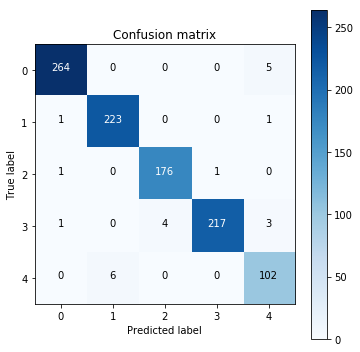

In [9]:
displayConfusionMatrix(y_test, y_pred,5)

=> Le résultat est plutôt bon.

### 1.3.2 Logistic Regression

Voyons maintenant la régression logistique.

In [10]:
lr = linear_model.LogisticRegression()
parameters = [{'penalty': ['l2', 'l1'],'C':np.logspace(-2,2,20)}]
lr_grid, y_pred = evaluateClassifier(lr,parameters, x_train, y_train, x_test, y_test )

Best params : {'C': 2.0691380811147901, 'penalty': 'l1'}
Classification accuracy: 97.91 % 


Confusion matrix, without normalization


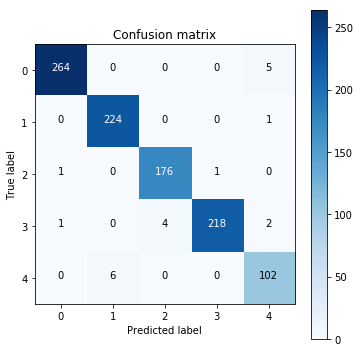

In [11]:
displayConfusionMatrix(y_test, y_pred,5)

=> Idem on a un score à plus de 98% !

### 1.3.3 Decision Tree

Classification avec un arbre de décision.

In [12]:
dtree = tree.DecisionTreeClassifier()
parameters = [{'criterion' : ['entropy', 'gini'], 'max_depth': [1, 2, 3, 4, 5],'max_features': [1,2,3]}]
dtree_grid, y_pred = evaluateClassifier(dtree,parameters, x_train, y_train, x_test, y_test)

Best params : {'criterion': 'entropy', 'max_depth': 5, 'max_features': 3}
Classification accuracy: 89.15 % 


Confusion matrix, without normalization


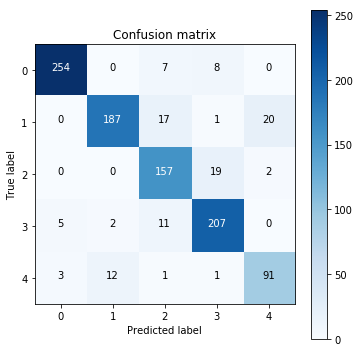

In [13]:
displayConfusionMatrix(y_test, y_pred,5)

=> Le score est moins élevé que les 2 précédents modèles même s'il reste plutôt bon.

### 1.3.4 KNN

Modèle KNN.

In [14]:
knn = neighbors.KNeighborsClassifier()
parameters = [{'n_neighbors': np.arange(1,50,1), 'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']}]
knn_grid, y_pred = evaluateClassifier(knn,parameters, x_train, y_train, x_test, y_test  )

Best params : {'algorithm': 'brute', 'n_neighbors': 1}
Classification accuracy: 97.61 % 


Confusion matrix, without normalization


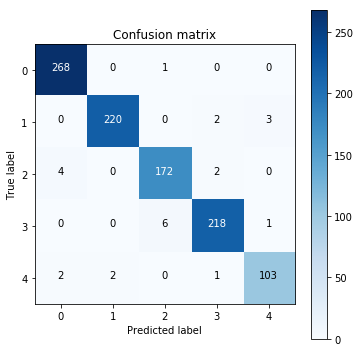

In [15]:
displayConfusionMatrix(y_test, y_pred,5)

=> Resultat toujours aussi encourageant au niveau du score de prédiction.

### 1.3.5 Random Forest

Testons maintenant un modèle ensembliste de type Forêt Aléatoire.

In [16]:
rfc = RandomForestClassifier(oob_score = True)
parameters = { 
    'n_estimators': [50, 100, 200, 700],
    'max_features': ['auto', 'sqrt', 'log2']
}
rfc_grid, y_pred = evaluateClassifier(rfc,parameters, x_train, y_train, x_test, y_test  )

Best params : {'max_features': 'log2', 'n_estimators': 50}
Classification accuracy: 98.61 % 


Confusion matrix, without normalization


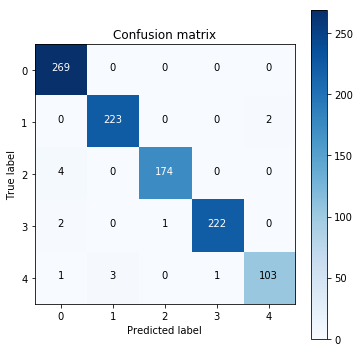

In [17]:
displayConfusionMatrix(y_test, y_pred,5)

=> Le score est très bon (98,68%).

### 1.3.6 Gradient Boosting

Le gradient boosting est très utilisé quand il s'agit d'utiliser les arbres de décision.

In [18]:
gb = ensemble.GradientBoostingClassifier()
parameters = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
gb_grid, y_pred = evaluateClassifier(gb,parameters, x_train, y_train, x_test, y_test  )

Best params : {'n_estimators': 90}
Classification accuracy: 99.10 % 


Confusion matrix, without normalization


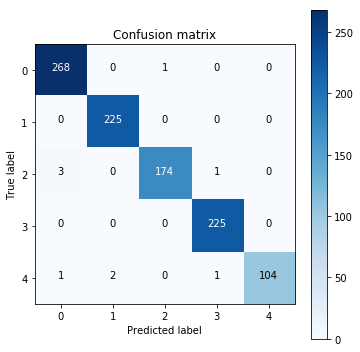

In [19]:
displayConfusionMatrix(y_test, y_pred,5)

=> Un très bon score aussi avec ce modèle.

### 1.3.7 XGBoost

Essayons maintenant un variante du Gradient Boosting. Nous essons l'Extreme Gradient Boosting qui est un algorithme Open Source.

In [20]:
xgb_model = xgb.XGBClassifier()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.05], #so called `eta` value
              'max_depth': [6],
              'min_child_weight': [11],
              'silent': [1],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'n_estimators': [5], #number of trees, change it to 1000 for better results
              'missing':[-999],
              'seed': [1337]}
xgb_grid, y_pred = evaluateClassifier(xgb_model,parameters, x_train, y_train, x_test, y_test  )

Best params : {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 11, 'missing': -999, 'n_estimators': 5, 'nthread': 4, 'objective': 'binary:logistic', 'seed': 1337, 'silent': 1, 'subsample': 0.8}
Classification accuracy: 95.32 % 


Confusion matrix, without normalization


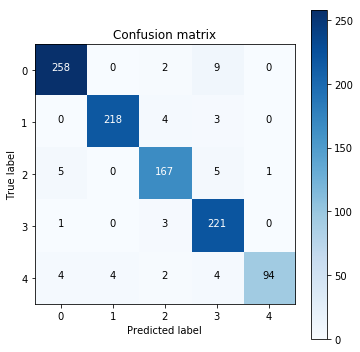

In [21]:
displayConfusionMatrix(y_test, y_pred,5)

=> Le score reste très correct (96%) mais moins bon que d'autres algorithmes précédents. Cependant on peut noter la rapidité d'execution de l'algorithme.

## 1.4 Bilan des évalutions de modèles

Affichons les scores de chacun des modèles testés

In [35]:
models = { 'Support Vector Machine' : svc_grid, 'Logistic Regression' : lr_grid, 'K-NN' : knn_grid, 
          'Decision Tree' : dtree_grid, 'Random Forest' : rfc_grid, 'Gradient Boosting' : gb_grid, 'XGBoost' : xgb_grid}
for k, v in models.items() :
    print("{:s} : best score = {:.3f}%".format(k,v.best_score_*100))

Support Vector Machine : best score = 97.184%
Logistic Regression : best score = 97.227%
K-NN : best score = 98.123%
Decision Tree : best score = 89.590%
Random Forest : best score = 98.720%
Gradient Boosting : best score = 98.805%
XGBoost : best score = 93.985%


Les 3 algorithmes donnant les meilleurs resultats : **gradient boosting, random forest et knn.**

### 1.4.1 Agregation des meilleurs modèles

Voyons si on améliore le score en faisant une combinaison des 3 meilleurs algorithmes.

In [39]:
knn_best  = neighbors.KNeighborsClassifier(**knn_grid.best_params_)
rf_best  = RandomForestClassifier(**rfc_grid.best_params_)
gb_best = ensemble.GradientBoostingClassifier(**gb_grid.best_params_)

In [40]:
votingC = ensemble.VotingClassifier(estimators=[('knn',knn_best),('gb',gb_best),('rf',rf_best)], voting='soft') 

In [41]:
votingC = votingC.fit(x_train,y_train)

In [42]:
y_pred = votingC.predict(x_test)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(y_test, y_pred)))

Precision: 98.11 % 


=> Nous obtenons un excellent score qui est le meilleur de tous nos algorithmes.

Nous ajoutons aussi ce modèle à notre ensemble.

In [43]:
models['Voting Classifier'] = votingC

## 1.5 Validation par le jeu de test

### 1.5.1 Chargement du jeu de test

Pour mesure la stabilité de nos modèles, on va faire des prédictions sur le jeu de tests qui a été créé pendant la phase de clustering.
Pour rappel, nous avons séparé nos données en jeu de test et d'entrainement et appliqué le clustering uniquement sur le jeu d'entrainement. L'objectif était de ne pas biaiser l'étape classification.

In [28]:
customers_test_TS = pd.read_csv('customers_test_TS.csv')

In [29]:
customers_test_TS.shape

(2990, 11)

On charge notre algorithme de clustering utilisé pour le test avec horizon temporel

In [30]:
from sklearn.externals import joblib
kmeans = joblib.load('kmeans_cluster_TS.pkl') 

### 1.5.2 Prédiction des clusters

On prédit les clusters avec notre algorithme kmeans. Ce sera notre target variable et celle qui permettra de vérifier la qualité des classifications.

Les clients seront affectées au cluster ayant le centroide le plus proche (avec la méthode predict).

In [31]:
y_test_customers_labels = kmeans.predict(customers_test_TS)

Regardons la répartitions des clients.

In [32]:
pd.DataFrame(pd.Series(y_test_customers_labels).value_counts(), columns = ['NbCustomers']).sort_values(by='NbCustomers',ascending=False).T

,0,3,2,1,4
NbCustomers,875,809,578,459,269


=> La répartition parait cohérente.

### 1.5.3 Stabilité des modèles de classification

In [33]:
for m in models :
    print(m)

Support Vector Machine
Logistic Regression
K-NN
Decision Tree
Random Forest
Gradient Boosting
XGBoost
Voting Classifier


In [44]:
for m_label, model in models.items() :
    y_predicted= model.predict(customers_test_TS)
    score = 100*metrics.accuracy_score(y_test_customers_labels, y_predicted)
    print("{:s} : Precision = {:.3f}%".format(m_label,score))

Support Vector Machine : Precision = 98.060%
Logistic Regression : Precision = 98.060%
K-NN : Precision = 97.057%
Decision Tree : Precision = 91.639%
Random Forest : Precision = 98.161%
Gradient Boosting : Precision = 98.528%
XGBoost : Precision = 95.686%
Voting Classifier : Precision = 97.391%


Les scores obtenus sont très bons. Nous obtenons le meilleur score avec la regression logistique mais le SVM, le Gradient Boosting, le Random Forest et le Voting Classifier nous donne tous un score supérieur à 98%.

## 2. Tests des modèles de classification sur le découpage aléatoire des clients

Dans cette section nous avons de nouveau évaluer différents algorithmes de classification mais cette fois-ci avecnotre jeu de données clients découpé de manière aléatoire.

## 2.1 Importation des données

In [45]:
customers_clusters_Random = pd.read_csv('customers_clusters_Random.csv')

In [46]:
customers_clusters_Random.shape

(3032, 12)

## 2.2 Préparation des données

In [48]:
Y = customers_clusters_Random['Cluster']
X = customers_clusters_Random.drop(['Cluster'], axis=1)

Découpage en jeu d'entrainement et de test.

In [49]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(X,Y,test_size = 0.3,random_state = 0)

## 2.3 Evaluation des modèles

### 2.3.1 SVM Linéaire

In [55]:
svc = svm.LinearSVC()
parameters = [{'C':np.logspace(-3,3,10)}]
svc_grid2, y_pred = evaluateClassifier(svc,parameters, x_train, y_train, x_test, y_test  )

Best params : {'C': 2.154434690031882}
Classification accuracy: 97.47 % 


Confusion matrix, without normalization


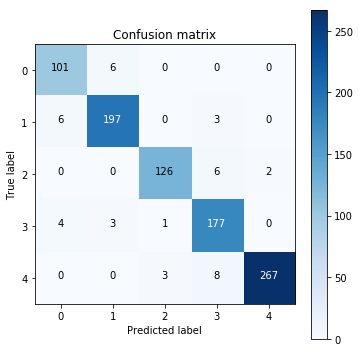

In [62]:
displayConfusionMatrix(y_test, y_pred,5)

### 2.3.2 Regression logistique

In [56]:
lr = linear_model.LogisticRegression()
parameters = [{'penalty': ['l2', 'l1'],'C':np.logspace(-2,2,20)}]
lr_grid2, y_pred = evaluateClassifier(lr,parameters, x_train, y_train, x_test, y_test )

Best params : {'C': 8.8586679041008232, 'penalty': 'l1'}
Classification accuracy: 98.13 % 


Confusion matrix, without normalization


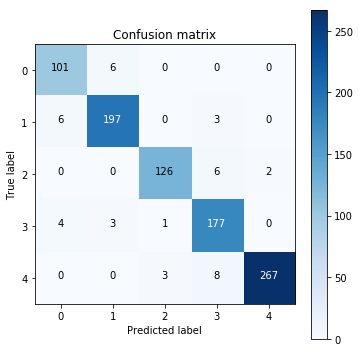

In [63]:
displayConfusionMatrix(y_test, y_pred,5)

### 2.3.3 Decision Tree

In [57]:
dtree = tree.DecisionTreeClassifier()
parameters = [{'criterion' : ['entropy', 'gini'], 'max_depth': [1, 2, 3, 4, 5],'max_features': [1,2,3]}]
dtree_grid2, y_pred = evaluateClassifier(dtree,parameters, x_train, y_train, x_test, y_test)

Best params : {'criterion': 'entropy', 'max_depth': 5, 'max_features': 3}
Classification accuracy: 88.13 % 


Confusion matrix, without normalization


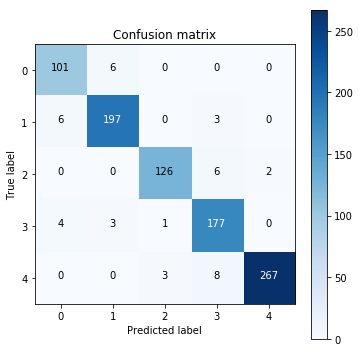

In [64]:
displayConfusionMatrix(y_test, y_pred,5)

### 2.3.4 KNN

In [58]:
knn = neighbors.KNeighborsClassifier()
parameters = [{'n_neighbors': np.arange(1,50,1), 'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']}]
knn_grid2, y_pred = evaluateClassifier(knn,parameters, x_train, y_train, x_test, y_test  )

Best params : {'algorithm': 'auto', 'n_neighbors': 1}
Classification accuracy: 97.80 % 


Confusion matrix, without normalization


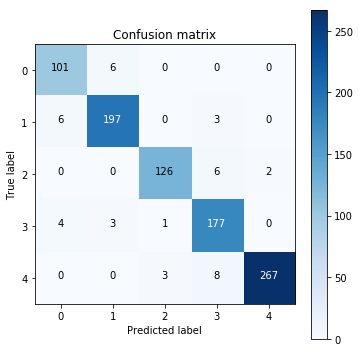

In [65]:
displayConfusionMatrix(y_test, y_pred,5)

### 2.3.5 Random Forest

In [60]:
rfc = RandomForestClassifier(oob_score = True)
parameters = { 
    'n_estimators': [50, 100, 200, 700],
    'max_features': ['auto', 'sqrt', 'log2']
}
rfc_grid2, y_pred = evaluateClassifier(rfc,parameters, x_train, y_train, x_test, y_test  )

Best params : {'max_features': 'auto', 'n_estimators': 100}
Classification accuracy: 98.46 % 


Confusion matrix, without normalization


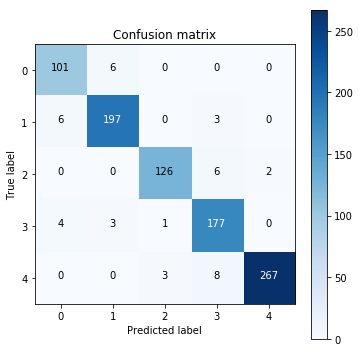

In [66]:
displayConfusionMatrix(y_test, y_pred,5)

### 2.3.6 Gradient Boosting

In [59]:
gb = ensemble.GradientBoostingClassifier()
parameters = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
gb_grid2, y_pred = evaluateClassifier(gb,parameters, x_train, y_train, x_test, y_test  )

Best params : {'n_estimators': 80}
Classification accuracy: 99.12 % 


Confusion matrix, without normalization


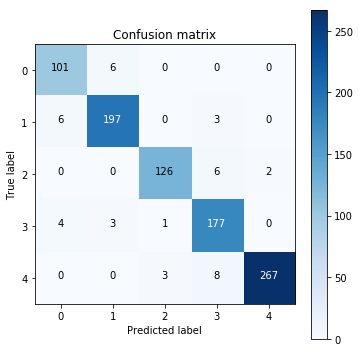

In [67]:
displayConfusionMatrix(y_test, y_pred,5)

### 2.3.7 XGBoost

In [61]:
xgb_model = xgb.XGBClassifier()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.05], #so called `eta` value
              'max_depth': [6],
              'min_child_weight': [11],
              'silent': [1],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'n_estimators': [5], #number of trees, change it to 1000 for better results
              'missing':[-999],
              'seed': [1337]}
xgb_grid2, y_pred = evaluateClassifier(xgb_model,parameters, x_train, y_train, x_test, y_test  )

Best params : {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 11, 'missing': -999, 'n_estimators': 5, 'nthread': 4, 'objective': 'binary:logistic', 'seed': 1337, 'silent': 1, 'subsample': 0.8}
Classification accuracy: 95.38 % 


Confusion matrix, without normalization


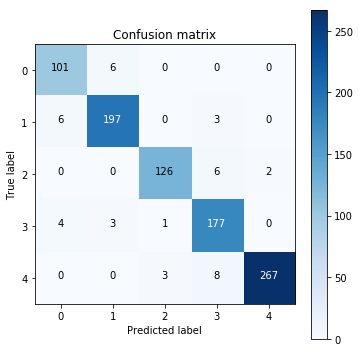

In [68]:
displayConfusionMatrix(y_test, y_pred,5)

## 2.4 Bilan des évalutions de modèles

In [76]:
models2 = { 'Support Vector Machine' : svc_grid2, 'Logistic Regression' : lr_grid2, 'K-NN' : knn_grid2, 
          'Decision Tree' : dtree_grid2, 'Random Forest' : rfc_grid2, 'Gradient Boosting' : gb_grid2, 'XGBoost' : xgb_grid2}
for k, v in models2.items() :
    print("{:s} : best score = {:.3f}%".format(k,v.best_score_*100))

Support Vector Machine : best score = 97.172%
Logistic Regression : best score = 97.926%
K-NN : best score = 97.078%
Decision Tree : best score = 86.098%
Random Forest : best score = 97.926%
Gradient Boosting : best score = 98.303%
XGBoost : best score = 94.251%


## 2.5 Validation par le jeu de test

### 2.5.1 Chargement du jeu de test

In [71]:
customers_test_Random = pd.read_csv('customers_test_Random.csv')

In [72]:
customers_test_Random.shape

(1331, 11)

On charge aussi notre algorithme de prédiction des clusters (kmeans)

In [73]:
kmeans_r = joblib.load('kmeans_cluster_Random.pkl') 

### 2.5.2 Prédiction des clusters

In [74]:
y_test_customers_labels = kmeans_r.predict(customers_test_Random)

In [75]:
pd.DataFrame(pd.Series(y_test_customers_labels).value_counts(), columns = ['NbCustomers']).sort_values(by='NbCustomers',ascending=False).T

,4,3,1,2,0
NbCustomers,382,303,291,206,149


### 2.5.3 Stabilité des modèles de classification

In [77]:
for m_label, model in models2.items() :
    y_predicted= model.predict(customers_test_Random)
    score = 100*metrics.accuracy_score(y_test_customers_labels, y_predicted)
    print("{:s} : Precision = {:.3f}%".format(m_label,score))

Support Vector Machine : Precision = 97.370%
Logistic Regression : Precision = 97.896%
K-NN : Precision = 97.896%
Decision Tree : Precision = 86.927%
Random Forest : Precision = 98.497%
Gradient Boosting : Precision = 98.648%
XGBoost : Precision = 94.816%
